$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
#device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/adihorowitz/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/adihorowitz/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/adihorowitz/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


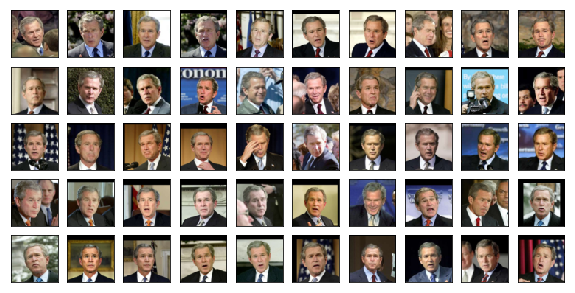

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 250, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=16000, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 250, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(1000, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([1,

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

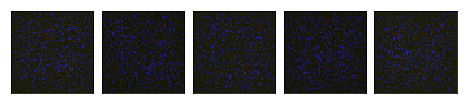

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 10, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.4, 0.999)}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.55it/s]
Discriminator loss: 0.34103528404717937
Generator loss:     5.146921718821806


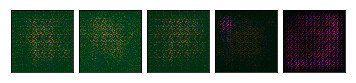

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.024796423995319533
Generator loss:     5.60721212274888


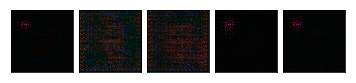

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.53it/s]
Discriminator loss: 0.044577081194695306
Generator loss:     7.200585000655231


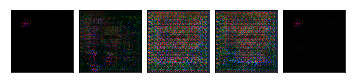

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.55it/s]
Discriminator loss: 0.011911132537266788
Generator loss:     6.035441510817584


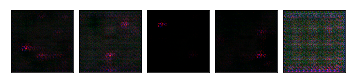

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.55it/s]
Discriminator loss: 1.118812178425929
Generator loss:     6.624750375747681


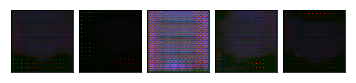

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.2786857840769431
Generator loss:     3.4699712921591366


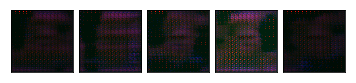

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.023954036919509664
Generator loss:     6.119651598088882


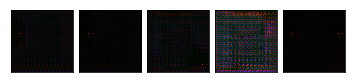

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.08484700267367504
Generator loss:     6.887709617614746


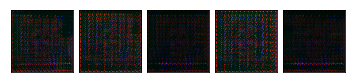

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: -0.002144188784501132
Generator loss:     8.518715858459473


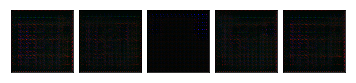

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.55it/s]
Discriminator loss: -0.010970810756963842
Generator loss:     8.347472499398624


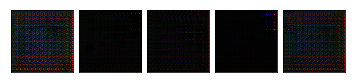

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.57it/s]
Discriminator loss: 0.08101108779802042
Generator loss:     7.7362081303316


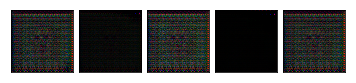

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.57it/s]
Discriminator loss: 0.30018024234210744
Generator loss:     6.435721649843104


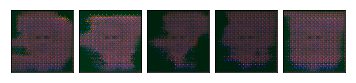

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.07039324895424001
Generator loss:     6.580133017371683


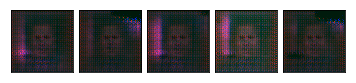

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.09968127376016449
Generator loss:     5.40990125431734


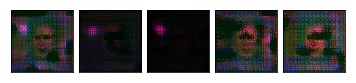

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.021781253025812262
Generator loss:     5.905278766856474


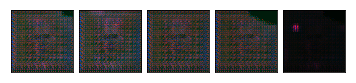

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.0658252708175603
Generator loss:     5.295387997346766


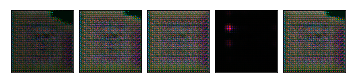

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.027108277139418265
Generator loss:     5.948320949778838


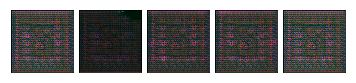

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.03889025572468253
Generator loss:     5.740783579209271


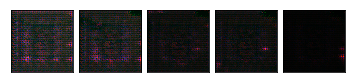

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.01007018577964867
Generator loss:     5.368624434751623


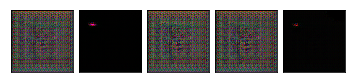

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.004205324194010566
Generator loss:     6.400594599106732


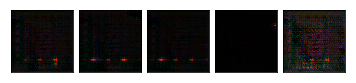

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.1380198374390602
Generator loss:     7.465507437201107


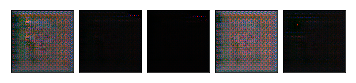

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.10504687183043536
Generator loss:     6.696813611423268


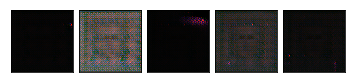

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.019423863905317643
Generator loss:     5.836121362798354


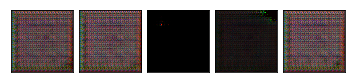

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: -0.009131940958254477
Generator loss:     6.242398766910329


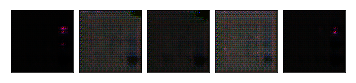

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.01742796183508985
Generator loss:     6.231314715217142


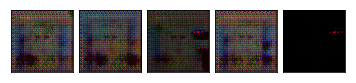

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
Discriminator loss: -0.06439688801765442
Generator loss:     7.6395300977370315


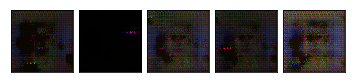

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: -0.025940378908725345
Generator loss:     7.064345780540915


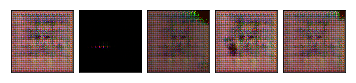

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: -0.07702530679457328
Generator loss:     7.954019462361055


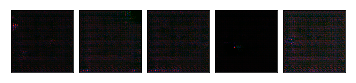

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.009473100523738301
Generator loss:     7.774297321543974


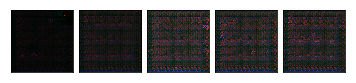

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.09363180289373678
Generator loss:     6.263979350819307


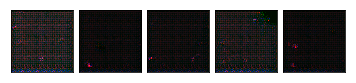

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: -0.005981160656494253
Generator loss:     7.8674876549664665


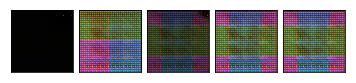

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.8706828559584477
Generator loss:     7.43834028524511


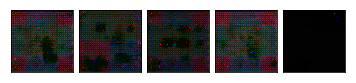

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.1680405339335694
Generator loss:     5.156349518719842


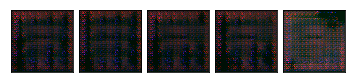

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.03247903232627055
Generator loss:     7.677857988020953


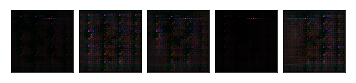

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.55it/s]
Discriminator loss: -0.02742980990339728
Generator loss:     6.153344070210176


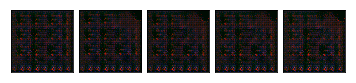

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.0676126114147551
Generator loss:     6.560282258426442


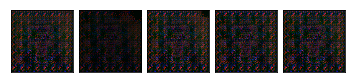

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: -0.04765383964952301
Generator loss:     9.34806520798627


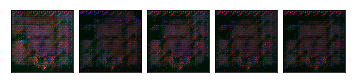

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.13191155431901708
Generator loss:     8.779211465050192


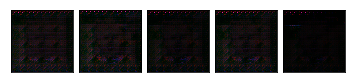

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.03652023326824693
Generator loss:     6.53384048798505


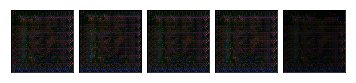

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.50it/s]
Discriminator loss: 0.06469770236050382
Generator loss:     7.774457398582907


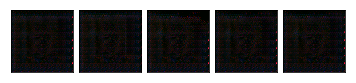

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.52it/s]
Discriminator loss: 0.06342816736330004
Generator loss:     6.389506143682143


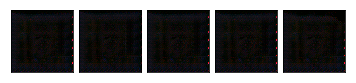

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: -0.07637523728258469
Generator loss:     8.493576751035803


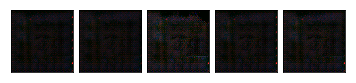

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.45it/s]
Discriminator loss: 0.04768997847157366
Generator loss:     9.751385090543943


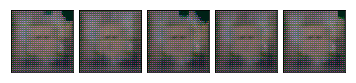

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.53it/s]
Discriminator loss: 1.0028756780221182
Generator loss:     6.054345481535968


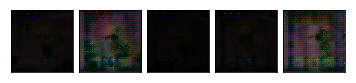

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.07946628803277717
Generator loss:     5.538096778533038


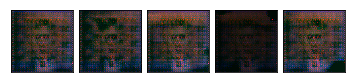

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.16462408948470564
Generator loss:     7.999386871562285


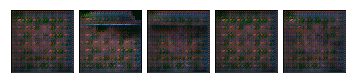

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.43211320141220794
Generator loss:     6.273203120512121


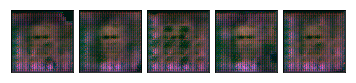

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.2077392162207294
Generator loss:     5.3064183697980996


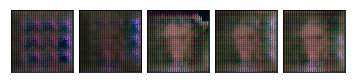

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.08725549354601432
Generator loss:     4.768601726083195


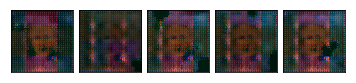

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.0961590571438565
Generator loss:     5.528309401343851


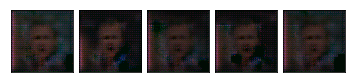

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.14359670877456665
Generator loss:     8.218700885772705


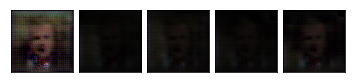

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.52it/s]
Discriminator loss: -0.003766841529046788
Generator loss:     5.411401860854205


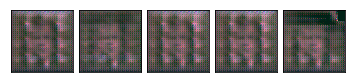

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.798319648951292
Generator loss:     6.689403000999899


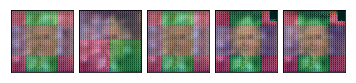

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.706798991517109
Generator loss:     4.2938424839692955


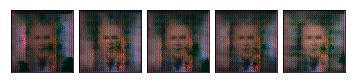

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.07321785543771352
Generator loss:     5.293606561772964


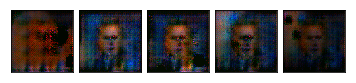

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.12830336556276856
Generator loss:     6.327303647994995


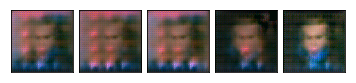

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
Discriminator loss: 1.209084078669548
Generator loss:     5.167398635078879


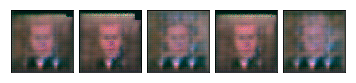

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.11271826714715537
Generator loss:     4.59663145682391


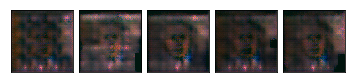

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.06571165384615169
Generator loss:     4.375614362604478


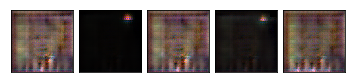

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.56it/s]
Discriminator loss: 0.06426712673376589
Generator loss:     4.844734780928668


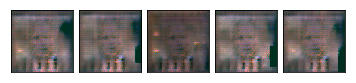

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.10662341599955279
Generator loss:     6.1641541509067315


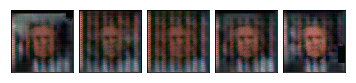

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.7598594959606143
Generator loss:     5.6962297979523155


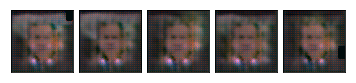

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.1273319431964088
Generator loss:     4.7357140428879685


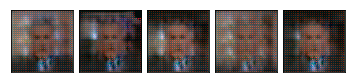

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.0848370036110282
Generator loss:     4.291990153929767


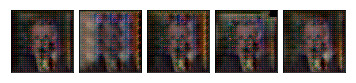

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.048956574762568754
Generator loss:     5.472500941332648


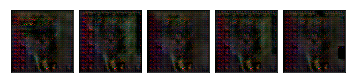

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.017234560978763244
Generator loss:     5.9463867299696975


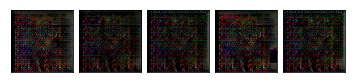

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.51it/s]
Discriminator loss: 0.041969383135437965
Generator loss:     6.064706101137049


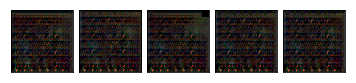

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.56it/s]
Discriminator loss: 0.031393312684753365
Generator loss:     6.364994161269244


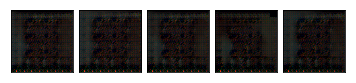

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.22739704698324203
Generator loss:     6.089545249938965


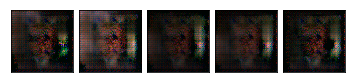

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 1.6708717670510798
Generator loss:     3.247571868055007


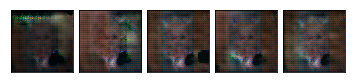

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.18398267578552752
Generator loss:     3.4740312940934124


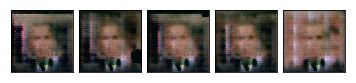

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.7753327274147201
Generator loss:     4.082200730548186


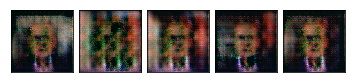

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.7651984090095058
Generator loss:     3.959187577752506


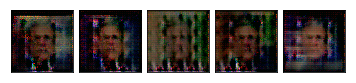

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.6754637117333272
Generator loss:     4.47212485706105


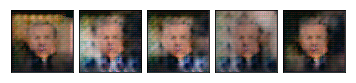

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.9865354983245626
Generator loss:     3.3391706347465515


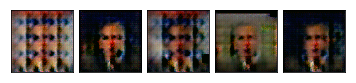

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.6753286728087593
Generator loss:     3.8163758897606064


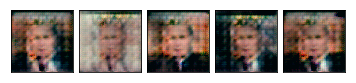

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.9996277987957001
Generator loss:     4.065025452305289


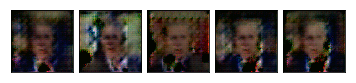

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.7480474920833812
Generator loss:     3.207898539655349


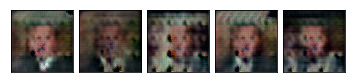

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.08125818827573
Generator loss:     3.0712651715559116


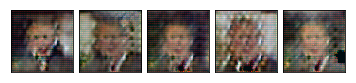

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.7110405774677501
Generator loss:     3.4508988787146175


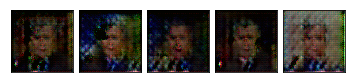

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8321015151108012
Generator loss:     3.1096186988493977


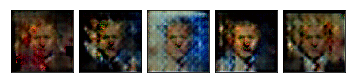

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.9688593429677627
Generator loss:     3.421896541819853


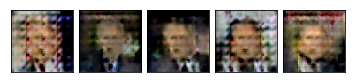

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.9789319126045003
Generator loss:     3.037009060382843


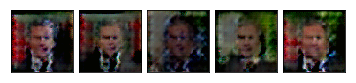

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0316879258436316
Generator loss:     3.1789211806129005


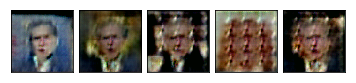

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0045741375754862
Generator loss:     2.8305161069421207


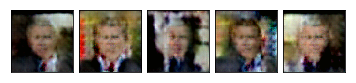

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.65it/s]
Discriminator loss: 0.9429325321141411
Generator loss:     2.842336563503041


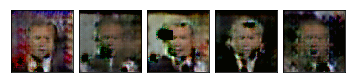

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.9566173974205466
Generator loss:     2.746894598007202


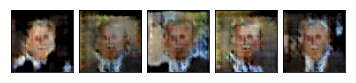

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
Discriminator loss: 0.9543381403474247
Generator loss:     3.020451072384329


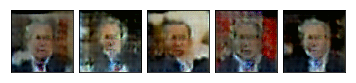

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 0.9370880126953125
Generator loss:     2.802240315605612


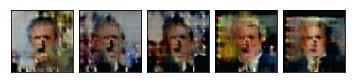

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.9982374240370357
Generator loss:     3.082949589280521


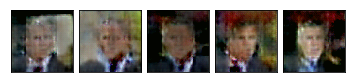

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.50it/s]
Discriminator loss: 0.8213815654025358
Generator loss:     2.886381945189308


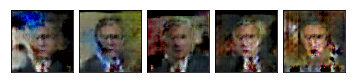

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.9172559275346643
Generator loss:     3.2135829224305996


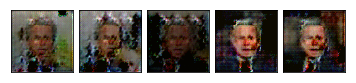

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.6348965816638049
Generator loss:     3.3897638040430405


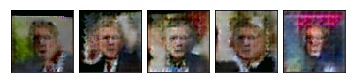

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.9432850970941431
Generator loss:     3.1853944922194763


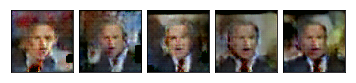

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.9264842657481923
Generator loss:     2.975524102940279


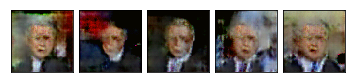

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.7416812163942
Generator loss:     3.191307306289673


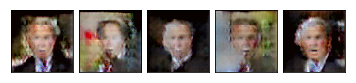

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.8711117804050446
Generator loss:     3.5701784877216114


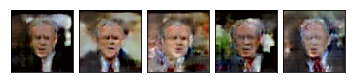

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.848643967333962
Generator loss:     3.3801620777915504


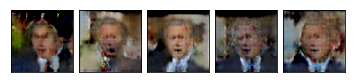

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.730099990087397
Generator loss:     2.931302372147055


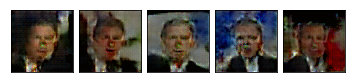

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.7271980818580178
Generator loss:     3.572612397810992


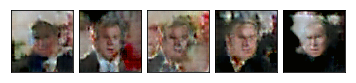

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)
torch.save(gan, 'gan_final.pt')



*** Images Generated from best model:


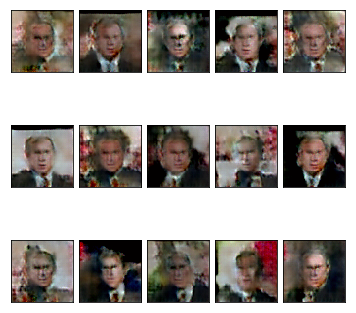

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
#from cs236605.answers import display_answer
#import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
#display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
#display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
#display_answer(hw3.answers.part3_q3)